In [1]:
from sentence_transformers import (
    SentenceTransformer,
    InputExample,
    losses,
    SentenceTransformerTrainingArguments,
    SentenceTransformerTrainer,
)

from sentence_transformers.evaluation import (
    BinaryClassificationEvaluator,
    SimilarityFunction,
)

from transformers import AutoConfig, AutoTokenizer, AutoModel

from torch import nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import wandb

In [3]:
model_id = "BAAI/bge-base-en-v1.5"

# configuration = AutoConfig.from_pretrained(model_id)
# configuration.hidden_dropout_prob = 0.5
# configuration.attention_probs_dropout_prob = 0.5

# tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModel.from_pretrained(model_id, config=configuration)

model = SentenceTransformer(model_id)

In [6]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [7]:
n_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters {n_train_params}')

Number of trainable parameters 109482240


In [17]:
dataset = load_dataset("csv", data_files="../data/train.csv")

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 26368
    })
})

In [18]:
dataset = dataset.remove_columns('id')
dataset = dataset.rename_column('question1', 'text1')
dataset = dataset.rename_column('question2', 'text2')
dataset = dataset.rename_column('target', 'label')

In [21]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(dataset['train']['label']),
    y=dataset['train']['label']
)

In [22]:
class_weights

array([0.74309548, 1.5284025 ])

In [23]:
def compute_weights(label_col, weight_0=class_weights[0], weight_1=class_weights[1]):
    """ Assign weights based on label imbalance. """
    return [weight_0 if label == 0 else weight_1 for label in label_col]

dataset = dataset.map(lambda x: {"weight": compute_weights([x["label"]])[0]})

Map:   0%|          | 0/26368 [00:00<?, ? examples/s]

In [24]:
dataset.column_names

{'train': ['text1', 'text2', 'label', 'weight']}

In [26]:
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

In [27]:
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

In [28]:
train_dataset.column_names

['text1', 'text2', 'label', 'weight']

In [30]:
from datasets import Dataset, DatasetDict, IterableDataset, IterableDatasetDict, Value

isinstance(train_dataset, IterableDataset)

False

In [31]:
train_dataset.features

{'text1': Value(dtype='string', id=None),
 'text2': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'weight': Value(dtype='float64', id=None)}

In [10]:
loss = losses.CosineSimilarityLoss(
    model,
    cos_score_transformation=nn.ReLU()
)

In [13]:
run_name = 'run_test'
output_dir = 'bge-base_' + run_name
learning_rate = 2e-4
dropout = 0.1
num_epochs = 10
batch_size=64
checkpoint_path=False

In [15]:
model[0].auto_model.embeddings.dropout.p = dropout

In [38]:
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir=output_dir,
    # Optional training parameters:
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    warmup_ratio=0.05,
    fp16=False,
    bf16=False,
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_cosine_roc_auc",
    greater_is_better=False,
    logging_steps=100,
    logging_dir="./logs",
    run_name=run_name,
    report_to="wandb",
)

In [11]:
from sentence_transformers.evaluation.SentenceEvaluator import SentenceEvaluator

from __future__ import annotations
from typing import TYPE_CHECKING, Literal

class RocAucEvaluator(SentenceEvaluator):
    def __init__(
        self,
        sentences1: list[str],
        sentences2: list[str],
        labels: list[int],
        name: str = "",
        batch_size: int = 64,
        clip_negative: bool = True,
        show_progress_bar: bool = False,
    ):
        super().__init__()

        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.labels = labels

        self.name = name
        self.batch_size = batch_size
        self.show_progress_bar = show_progress_bar

        self.clip_negative = clip_negative

    def __call__(
        self, model: SentenceTransformer, output_path: str = None, epoch: int = -1, steps: int = -1
    ) -> dict[str, float]:

        embeddings = model.encode(
            self.sentences1 + self.sentences2,
            batch_size=self.batch_size,
            show_progress_bar=self.show_progress_bar,
            convert_to_numpy=True,
        )
        embeddings1 = embeddings[: len(self.sentences1)]
        embeddings2 = embeddings[len(self.sentences1) :]

        labels = np.asarray(self.labels)

        similarity = 1 - paired_cosine_distances(embeddings1, embeddings2)
        if self.clip_negative:
            similarity[similarity < 0] = 0.0

        roc_auc = roc_auc_score(labels, similarity)

        return {'eval_cosine_roc_auc': roc_auc}
        

In [14]:
dev_evaluator = RocAucEvaluator(
    sentences1=test_dataset["text1"],
    sentences2=test_dataset["text2"],
    labels=test_dataset["label"],
    batch_size=batch_size,
    clip_negative=True,
)

In [41]:
wandb.finish()

wandb_run_name = f"bge-base-{run_name}_epochs-{num_epochs}"
wandb.init(
    project="DuplicateSearch",
    name=wandb_run_name,
    mode='offline',
    config={
        "learning_rate": learning_rate,
        "dropout": dropout,
        "comment": "Clipped loss",
    },
)

In [42]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)

trainer.train(resume_from_checkpoint=checkpoint_path)

Detected kernel version 5.3.18, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Cosine Roc Auc
100,0.011600,0.122171,0.907989
200,0.025200,0.126109,0.903051
300,0.035500,0.136931,0.902161
400,0.034000,0.130692,0.894940
500,0.033200,0.132489,0.902522
600,0.032300,0.136911,0.898772
700,0.027600,0.127759,0.908259
800,0.022200,0.129485,0.905147
900,0.028100,0.130339,0.900668
1000,0.030500,0.126762,0.900974


KeyboardInterrupt: 

## Test model

In [25]:
trainer.state.best_model_checkpoint

'bge-base_run_2/checkpoint-2300'

In [141]:
# model = SentenceTransformer(trainer.state.best_model_checkpoint)

In [17]:
def test_model(model, test_dataset, clip_negative=True):
    sentences1=test_dataset['text1']
    sentences2=test_dataset["text2"]
    labels=test_dataset["label"]

    sentences = sentences1 + sentences2
    embeddings = model.encode(
        sentences,
        normalize_embeddings=True,
        show_progress_bar=True,
        convert_to_numpy=True,
    )
    
    embeddings1 = embeddings[: len(sentences1)]
    embeddings2 = embeddings[len(sentences1) :]

    similarity = 1 - paired_cosine_distances(embeddings1, embeddings2)
    if clip_negative:
        similarity[similarity < 0] = 0.0
    return similarity

In [18]:
similarity = test_model(model, test_dataset)

Batches:   0%|          | 0/330 [00:00<?, ?it/s]

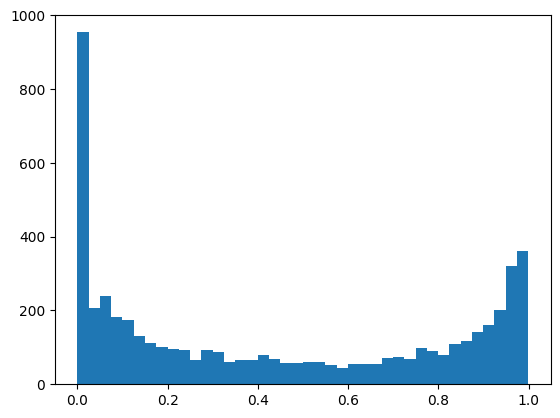

In [19]:
plt.hist(similarity, bins=40)
plt.show()

In [20]:
roc_auc = roc_auc_score(test_dataset['label'], similarity)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.931543087648941


In [21]:
wandb.log({"test/roc_auc": roc_auc})

In [15]:
roc_auc = dev_evaluator(model)['eval_cosine_roc_auc']
print(roc_auc)

0.8934628487514577
